In [18]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam

# Parameters
IMG_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 50  # Increased for better training
DATA_DIR = r"D:\asl_words\frames"

# Create data generators
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Save label names
class_indices = train_gen.class_indices
labels = list(class_indices.keys())
np.save("labels.npy", labels)

# Build a CNN with BatchNormalization
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(labels), activation='softmax')
])

# Compile the model with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks: Reduce LR + EarlyStopping + Save best model
lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    "best_model.h5",
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[lr_scheduler, early_stop, checkpoint]
)

# Save final model
model.save("asl_cnn_model.h5")
print("✅ Final model saved as asl_cnn_model.h5")


Found 1728 images belonging to 27 classes.
Found 432 images belonging to 27 classes.
Epoch 1/50
54/54 [==============================] - ETA: 0s - loss: 1.8919 - accuracy: 0.4705     
Epoch 1: val_accuracy improved from -inf to 0.05324, saving model to best_model.h5
54/54 [==============================] - 11s 201ms/step - loss: 1.8919 - accuracy: 0.4705 - val_loss: 3.2368 - val_accuracy: 0.0532 - lr: 1.0000e-04
Epoch 2/50
54/54 [==============================] - ETA: 0s - loss: 0.6674 - accuracy: 0.7917 
Epoch 2: val_accuracy improved from 0.05324 to 0.09491, saving model to best_model.h5
54/54 [==============================] - 11s 195ms/step - loss: 0.6674 - accuracy: 0.7917 - val_loss: 3.2090 - val_accuracy: 0.0949 - lr: 1.0000e-04
Epoch 3/50
54/54 [==============================] - ETA: 0s - loss: 0.4566 - accuracy: 0.8542 
Epoch 3: val_accuracy improved from 0.09491 to 0.10880, saving model to best_model.h5
54/54 [==============================] - 10s 191ms/step - loss: 0.4566 - 

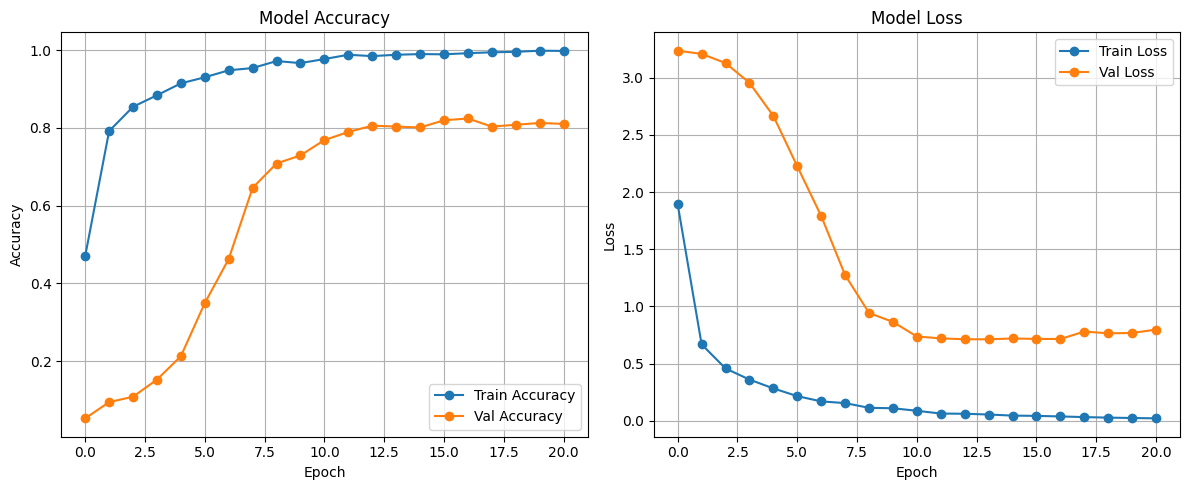

In [23]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [24]:
# Final epoch results
final_val_acc = history.history['val_accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]

# Best validation accuracy and corresponding loss
best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc)
best_val_loss = history.history['val_loss'][best_epoch]

print(f"📌 Final Validation Accuracy: {final_val_acc * 100:.2f}%")
print(f"📌 Final Validation Loss: {final_val_loss:.4f}")
print(f"🏅 Best Validation Accuracy: {best_val_acc * 100:.2f}% at epoch {best_epoch + 1}")
print(f"🏅 Corresponding Validation Loss: {best_val_loss:.4f}")


📌 Final Validation Accuracy: 81.02%
📌 Final Validation Loss: 0.7967
🏅 Best Validation Accuracy: 82.41% at epoch 17
🏅 Corresponding Validation Loss: 0.7143
